## This notebook includes

1. use of acoustic-prosodic, linguistic, and visual features for training models reported (tables IV and V in the paper
2. training pipeline for evaluating different models and their performance


In [1]:
#import libraries
import numpy as np
import scipy as sp
import pandas as pd
from sklearn import metrics
from sklearn.decomposition import PCA

#import models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import LinearSVC


# import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score

#for plotting
from matplotlib import pyplot as plt


In [ ]:
# read lexical-acoustic data
al_data = np.load("regularOnly.npy", allow_pickle = True)
al_data = np.delete(al_data, 3889, axis=1)
al_data = np.delete(al_data, 3894, axis=1)

#getting columns names ready for merging
feature_columns = ['feature_{}'.format(i) for i in range (2623, 9491)]
other_columns = ['id', 'speaker', 'label']
feature_cols = other_columns + feature_columns

#get final dataframe for verbal (acoustic-prosodic and linguistic information
al_data = pd.DataFrame(al_data, columns = feature_cols)
al_data

# read visual data
vis_data = pd.read_csv('/notebooks/features/data_OpenFace.csv', index_col = [0])

# merge acoustic-prosodic and visual data
final_dataset = pd.merge(vis_data, al_data.drop(columns =['speaker', 'label']), how = 'right', on = 'id', sort = True)
final_dataset = final_dataset.rename(columns = {"speaker_x":"speaker", "label_x": "label"})
final_dataset = final_dataset.dropna()

final_dataset


In [3]:
def plot_speaker_frequency(nameIndexDic, num=50):
    '''
    parameter:
    nameIndexDic: dict. the dictionary of the appearance count for each speaker
    num: int. indicate the first many speaker data to be drawn in the plot, default 50

    do:
    plot the histogram of each speaker and their record frequency
    '''
    #create x,y list
    name = np.array(list(nameIndexDic.keys()))
    freq = []
    for i in nameIndexDic.values():
        freq.append(len(i))
    freq = np.array(freq)
    index = np.argsort(freq)[::-1]
    name = name[index][:num]
    freq = freq[index][:num]
    fig = plt.figure(figsize = (10, 5))
    # creating the bar plot
    plt.bar(name, freq, color ='maroon',width = 0.4)
    plt.xlabel("speaker name")
    plt.ylabel("frequency")
    plt.xticks(rotation = 90)
    plt.title("Speaker Turn Frequency Plot")

    # Show plot
    plt.show()

Explained variance: 0.9999607025764631


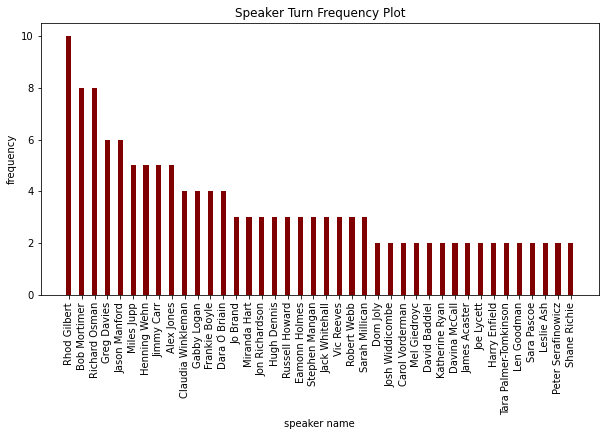

(275,) (74,)


In [4]:
def train_test_split_by_speaker(data, test_size=0.2, pca=False, numPC=300):
    '''
    parameters:
    data: the dataset that we will train the model on
    test_size: the percentage of test data, by default 0.2
    pca: Bool. True, if to conduct PCA on the dataset, by default False
    numPca: number of principal components, by default 50
    
    return:
    train_x:
    train_y:
    test_x:
    test_y:
    '''
    
    data = np.array(data)
    
    #get the speaker name column
    name = data[:,1]
    nameList = []
    nameIndexDic = {}
    for i in range(name.shape[0]):
        try: 
            nameIndexDic[name[i]].append(i)
        except:
            nameList.append(name[i])
            nameIndexDic[name[i]] = [i]
    nameList = np.array(nameList)
    np.random.shuffle(nameList)

    numOfVector = round(len(nameList)*test_size)
    
    
    testIndex = []
    trainIndex = []
    
    #create index list for train and test 
    for j in range(len(nameList)):
        
        #first get test dataset
        if j < numOfVector:
            testIndex = testIndex + nameIndexDic[nameList[j]]
        # rest for train dataset
        else: 
            trainIndex = trainIndex + nameIndexDic[nameList[j]]
    
    
    data = data[:,2:].astype(float)
    
    # normalizing 
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data[:, 1:])
    
    if pca == True:
        pcaModel = PCA(numPC) 
        
        pcaData = pcaModel.fit_transform(scaled_data)
        
        # to check the percentage of variance explained
        print('Explained variance:', np.sum(pcaModel.explained_variance_ratio_))
    
        scaled_data = pcaData
    
    #split data
    test = scaled_data[testIndex]
    train = scaled_data[trainIndex]

    
    #split labels
    test_l = data[testIndex]
    train_l = data[trainIndex]
    
    test_x = test.astype(float)
    test_y = test_l[:,0].astype(int)
    
    train_x = train.astype(float)
    train_y = train_l[:,0].astype(int)
    
    return train_x, train_y, test_x, test_y, nameIndexDic

train_X, train_Y, test_X, test_Y, dic = train_test_split_by_speaker(final_dataset, pca=True, test_size=0.2, numPC =100)
plot_speaker_frequency(dic, 40)
print(train_Y.shape, test_Y.shape)

In [5]:
def get_statistics(predict_y, real_y, ifNpArr=False):
    '''
    parameters:
    predict_y: npArr. the prediction array
    real_y: npArr. the actual label

    return:
    accuracy: float. 
    precision: float.
    recall: float.

    reference: https://mmuratarat.github.io/2019-10-01/how-to-compute-AUC-plot-ROC-by-hand
    '''
    #lie detection
    #lie is the positive class, truth is negative class
    assert predict_y.shape ==real_y.shape
    tp=0; tn=0; fp=0; fn=0
    for i in range(len(predict_y)):
        #the model predicts it is a lie/positive
        if predict_y[i] == 0:
            if real_y[i] == 0:
                tn += 1
            else:
                fn += 1 
        #the model predicts it is a truth/negative
        else:
            if real_y[i] == 1:
                tp += 1
            else:
                fp += 1

    # calculate evaluation metric
    accuracy = accuracy_score(real_y, predict_y)
    precision = precision_score(real_y, predict_y, average='weighted')
    recall = recall_score(real_y, predict_y, average='weighted')
    
    #specificity
    tn, fp, fn, tp = confusion_matrix(real_y, predict_y).ravel()
    specificity = tn / (tn+fp)
    
    #f1 score
    f1 = f1_score(real_y, predict_y, average='weighted')
    
    fpr, tpr, thresholds = metrics.roc_curve(real_y, predict_y)
    auc = metrics.auc(fpr, tpr)
    
    print(classification_report(real_y, predict_y))

    if ifNpArr:
        return np.array([accuracy, precision, recall, specificity, f1, auc])
    else:
        return {"accuracy":"%.3f" % accuracy, "precision":"%.3f" % precision, "recall":"%.3f" % recall, "specificity":"%.3f" % specificity, "f1":"%.3f" % f1, "auc":"%.3f" % auc}
        

In [6]:
def run_model_n_times(modelType, n=10, pca=False, numPC=50):
    statistics = np.array([0,0,0,0,0,0])
    #choose the model type
    if modelType == "LR":
        model = LogisticRegression(max_iter = 1000)
    elif modelType == "RF":
        model = RandomForestClassifier()
    elif modelType == "DT":
        model = DecisionTreeClassifier()
    elif modelType == "NB":
        model = GaussianNB()
    elif modelType == "MLP":
        model = MLPClassifier(hidden_layer_sizes=(1095, 1095, 1095, 1095, 1095, 1095),solver="sgd",learning_rate_init=0.00134, max_iter = 2000)
    elif modelType == "Ada":
        model = AdaBoostClassifier()
    elif modelType == "LSVM":
        model = LinearSVC(max_iter = 20000)

    
    statistics = []
    for i in range(n):
        #create train and test splits
        train_X, train_Y, test_X, test_Y, _ = train_test_split_by_speaker(df, pca = pca, numPC=numPC, test_size=0.1)
        
        #train
        model.fit(train_X, train_Y)
        predict_y = model.predict(test_X)
        # print(predict_y.shape, test_Y.shape)
        result = get_statistics(predict_y, test_Y, True)
        statistics.append(result)
    
    df1 = pd.DataFrame(statistics)
    std = df1.std()*100
    mean = df1.mean()*100
    upper = mean + std
    lower = mean - std
    
    #print out the result
    metricList = ["accuracy", "precision", "recall", "specificity", "f1", "auc"]
    for i in range(6):
        print(metricList[i], "\t", "{:.2f}".format(mean[i]), "{:.2f}".format(lower[i]) + "-" + "{:.2f}".format(upper[i]))

In [ ]:
run_model_n_times("LR",pca=False, numPC=100)

In [ ]:
run_model_n_times("RF",pca=False, numPC=100)

In [ ]:
run_model_n_times("DT",pca=False, numPC=100)

In [ ]:
run_model_n_times("NB",pca=False, numPC=100)

In [ ]:
run_model_n_times("MLP",pca=False, numPC=100)

In [ ]:
run_model_n_times("Ada",pca=False, numPC=100)

In [ ]:
run_model_n_times("LSVM",pca=False, numPC=100)